# Selection Task

## Restructuring for One-vs-Rest

The "animals" directory contains 90 different labels and each folder contains 60 images of each animal

For One-vs-Rest classification, we'll choose bat as our positive sample

The following code creates the appropriate directory structure, if it does not exist.

This notebook must be present in the same directory as the "animal" directory for the code to work.

Selecting 5 random images from each class to build the "others" label.

In [91]:
import os
import shutil
import random
src_folder = "animals/bat"
folders = os.listdir("animals")
temp = []
for folder in folders:
    if folder != "bat":
        temp.append([os.path.join("animals/"+folder, file) for file in random.sample(os.listdir("animals/"+folder),5)])
to_copy=[]
for temp_list in temp:
    for item in temp_list:
        to_copy.append(item)
if not os.path.exists("one-vs-rest"):
    shutil.copytree(src_folder, "one-vs-rest/bat")
    os.mkdir("one-vs-rest/others")
    for file_name in to_copy:
        shutil.copy2(file_name, "one-vs-rest/others/")

## Using existing architecture (ResNet) for binary classification (One vs Rest)

In [92]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [93]:
import pathlib
data_dir = pathlib.Path("one-vs-rest")

img_height,img_width=140,140
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 505 files belonging to 2 classes.
Using 404 files for training.
Found 505 files belonging to 2 classes.
Using 101 files for validation.


In [94]:
class_names = train_ds.class_names
print(class_names)

['bat', 'others']


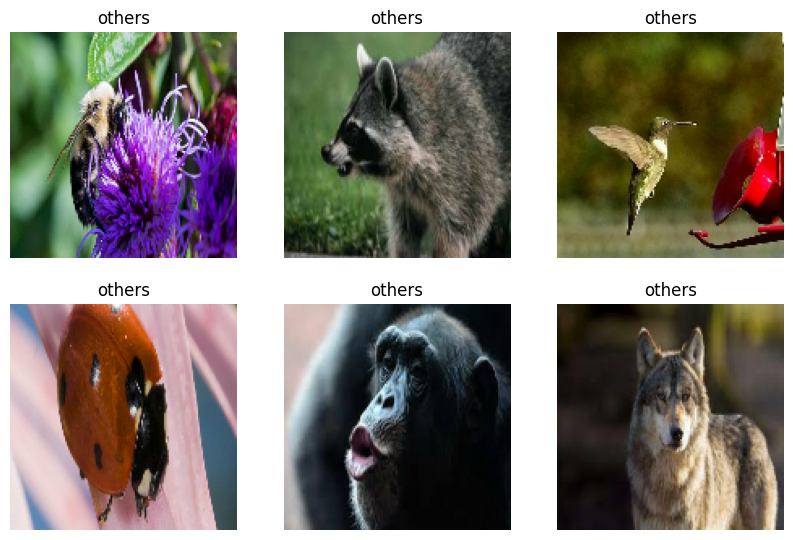

In [95]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [96]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(140,140,3),
                   pooling='avg',classes=2,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(1, activation='softmax'))

In [97]:
resnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 module_wrapper_9 (ModuleWra  (None, 2048)             0         
 pper)                                                           
                                                                 
 module_wrapper_10 (ModuleWr  (None, 512)              1049088   
 apper)                                                          
                                                                 
 module_wrapper_11 (ModuleWr  (None, 1)                513       
 apper)                                                          
                                                                 
Total params: 24,637,313
Trainable params: 1,049,601
Non-trainable params: 23,587,712
__________________________________

In [98]:
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [99]:
epochs=10
history = resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
13/13 [==============================] - 5s 149ms/step - loss: 0.9790 - accuracy: 0.8837 - val_loss: 0.1918 - val_accuracy: 0.8713
Epoch 2/10
13/13 [==============================] - 1s 71ms/step - loss: 0.1702 - accuracy: 0.8837 - val_loss: 0.1774 - val_accuracy: 0.8713
Epoch 3/10
13/13 [==============================] - 1s 70ms/step - loss: 0.0871 - accuracy: 0.8837 - val_loss: 0.2082 - val_accuracy: 0.8713
Epoch 4/10
13/13 [==============================] - 1s 71ms/step - loss: 0.0491 - accuracy: 0.8837 - val_loss: 0.1651 - val_accuracy: 0.8713
Epoch 5/10
13/13 [==============================] - 1s 71ms/step - loss: 0.0245 - accuracy: 0.8837 - val_loss: 0.2014 - val_accuracy: 0.8713
Epoch 6/10
13/13 [==============================] - 1s 71ms/step - loss: 0.0132 - accuracy: 0.8837 - val_loss: 0.2158 - val_accuracy: 0.8713
Epoch 7/10
13/13 [==============================] - 1s 72ms/step - loss: 0.0081 - accuracy: 0.8837 - val_loss: 0.2160 - val_accuracy: 0.8713
Epoch 8/10
1

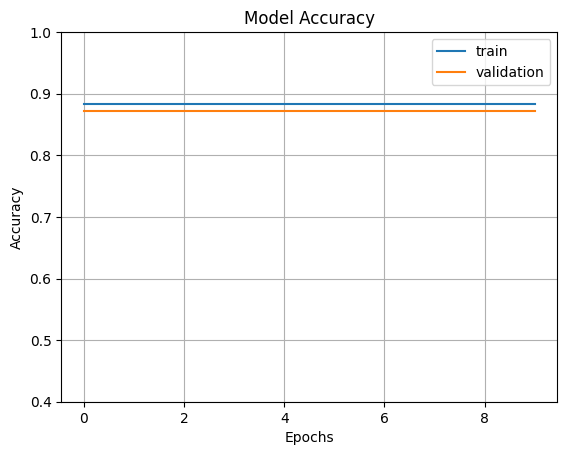

In [100]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

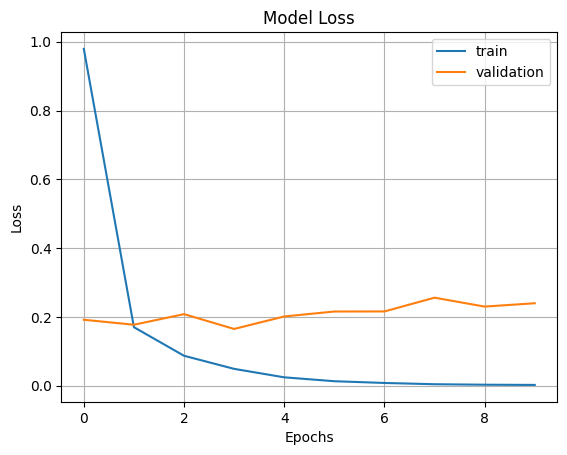

In [101]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()


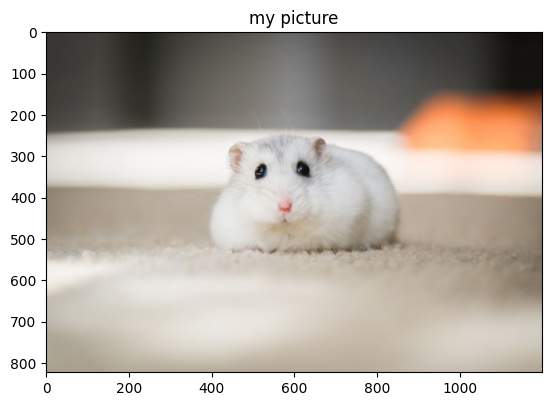

(1, 140, 140, 3)


In [111]:
import cv2
image=cv2.imread("C:\\Users\\suvid\\Desktop\\hamster.jpg")
image_resized= cv2.resize(image, (img_height,img_width))

RGB_im = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_im)
plt.title('my picture')
plt.show()
image=np.expand_dims(image_resized,axis=0)

print(image.shape)

In [112]:
pred=resnet_model.predict(image)
print(pred)

1/1 [==============================] - 0s 23ms/step
[[1.]]


In [113]:
output_class=class_names[np.argmax(pred)]
print("The predicted class is", output_class)

The predicted class is bat
